In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor

In [2]:
file_path = '../data_source/premiums_young.xlsx'
df = pd.read_excel(file_path)
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [3]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

### Handle NA Values

In [4]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicate values

In [5]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


### Handle Outliers

In [6]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [7]:
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [8]:
df[df.age > 100]['age'].unique()

array([], dtype=int64)

In [9]:
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

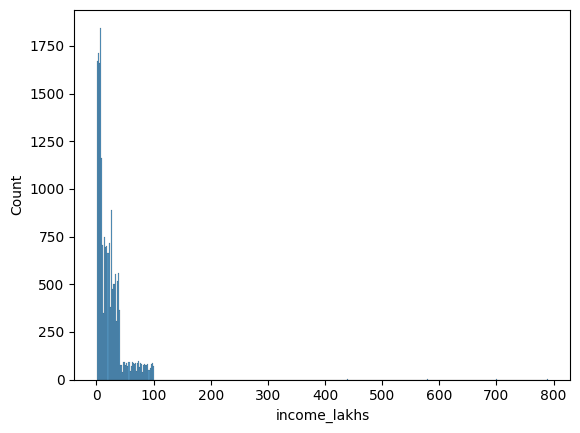

In [10]:
sns.histplot(df1.income_lakhs)

In [11]:
df1.income_lakhs.quantile([0.25,0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [12]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [13]:
get_iqr_bounds(df1.income_lakhs)

(-31.5, 68.5)

In [14]:
quantile_threshold = df1.income_lakhs.quantile(.999)

In [15]:
df1[df1.income_lakhs > quantile_threshold].shape

(4, 13)

In [16]:
df2 = df1[df1.income_lakhs < quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20054.000000,20054.000000,20054.000000,20054.000000
mean,21.494016,0.722449,22.266530,8136.902413
std,2.294382,0.937033,21.526939,2748.132286
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6019.000000
50%,21.000000,0.000000,16.000000,7936.500000
75%,23.000000,1.000000,31.000000,9552.750000
max,25.000000,3.000000,99.000000,18186.000000


In [17]:
numeric_columns = df.select_dtypes(include=['int', 'float']).columns

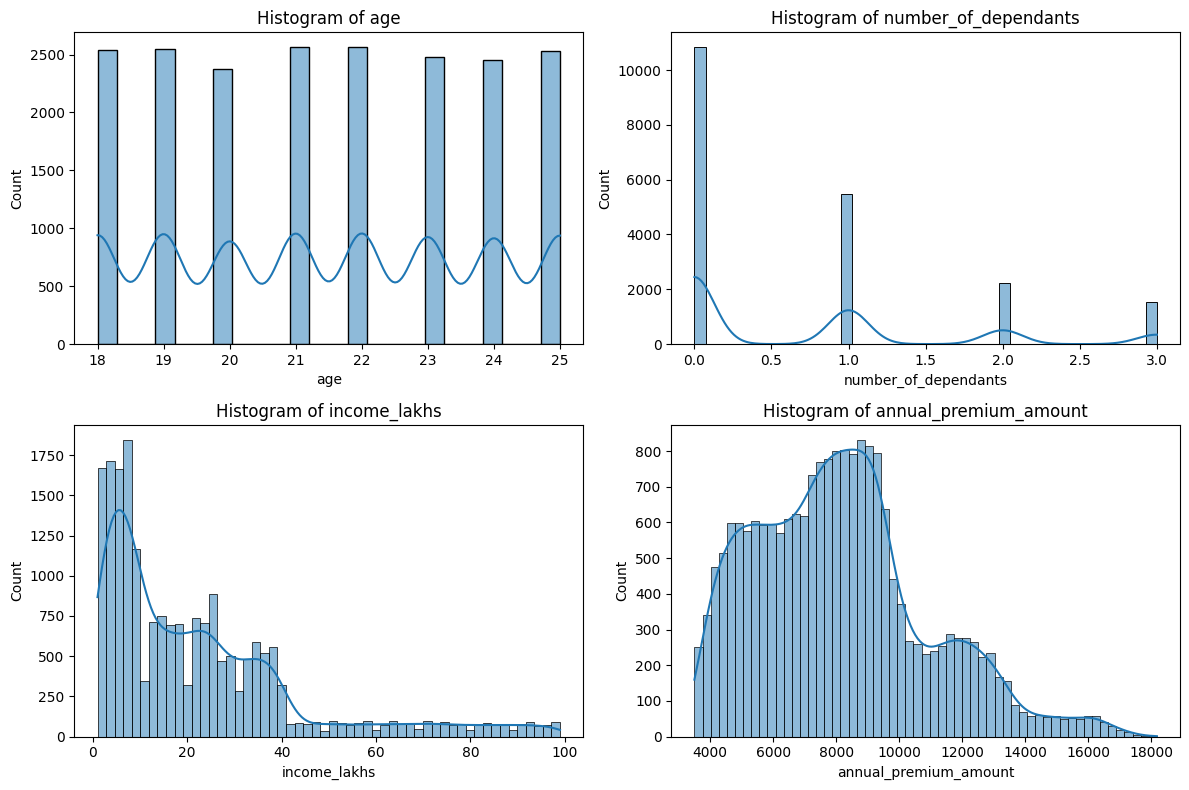

In [18]:
numeric_columns = df2.select_dtypes(include=['int', 'float']).columns

fig, axes = plt.subplots(2, 2, figsize=(12, 8))


axes = axes.flatten()
for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

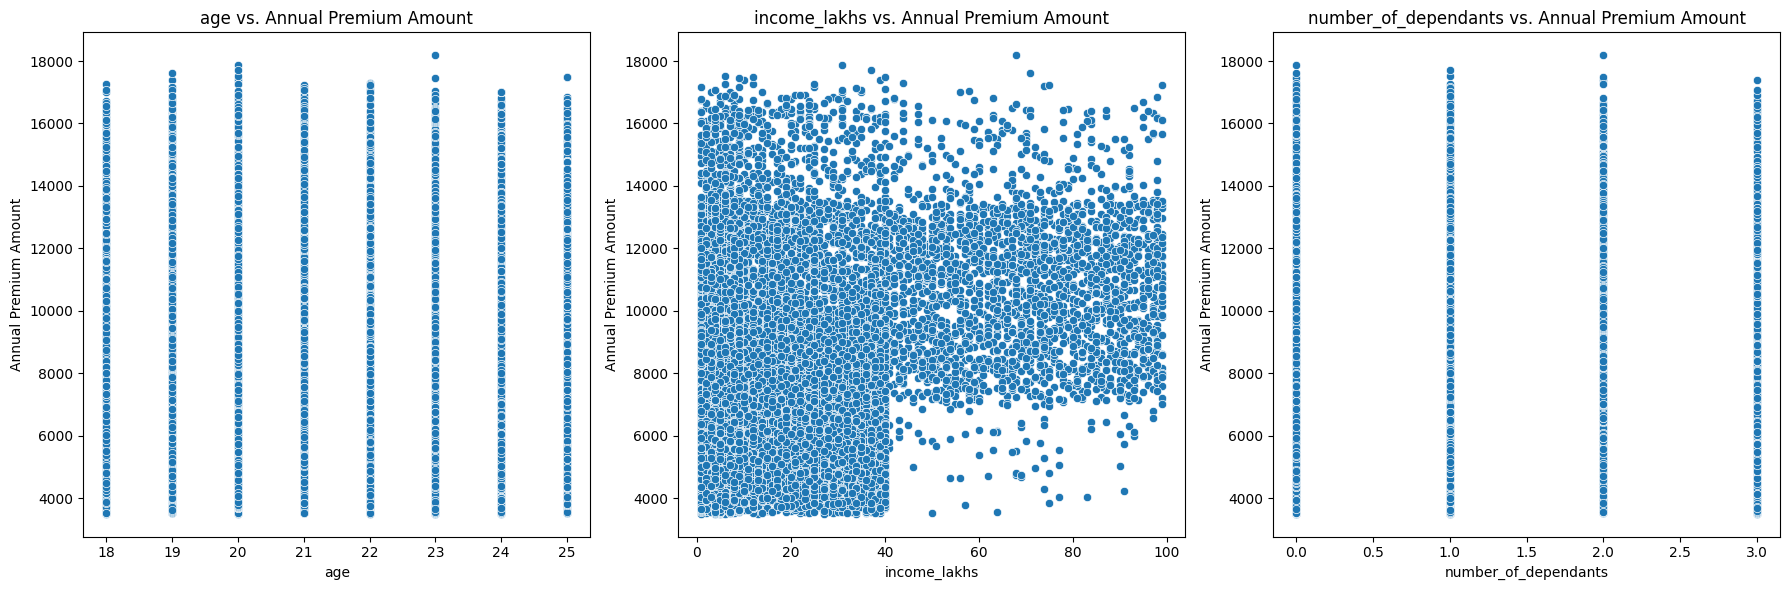

In [19]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

In [20]:
categorical_cols = df.select_dtypes(include=['object']).columns

In [21]:
for col in categorical_cols:
    print(col, ":" ,df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [22]:
df2['smoking_status'].replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
}, inplace = True)

df2['smoking_status'].unique()


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

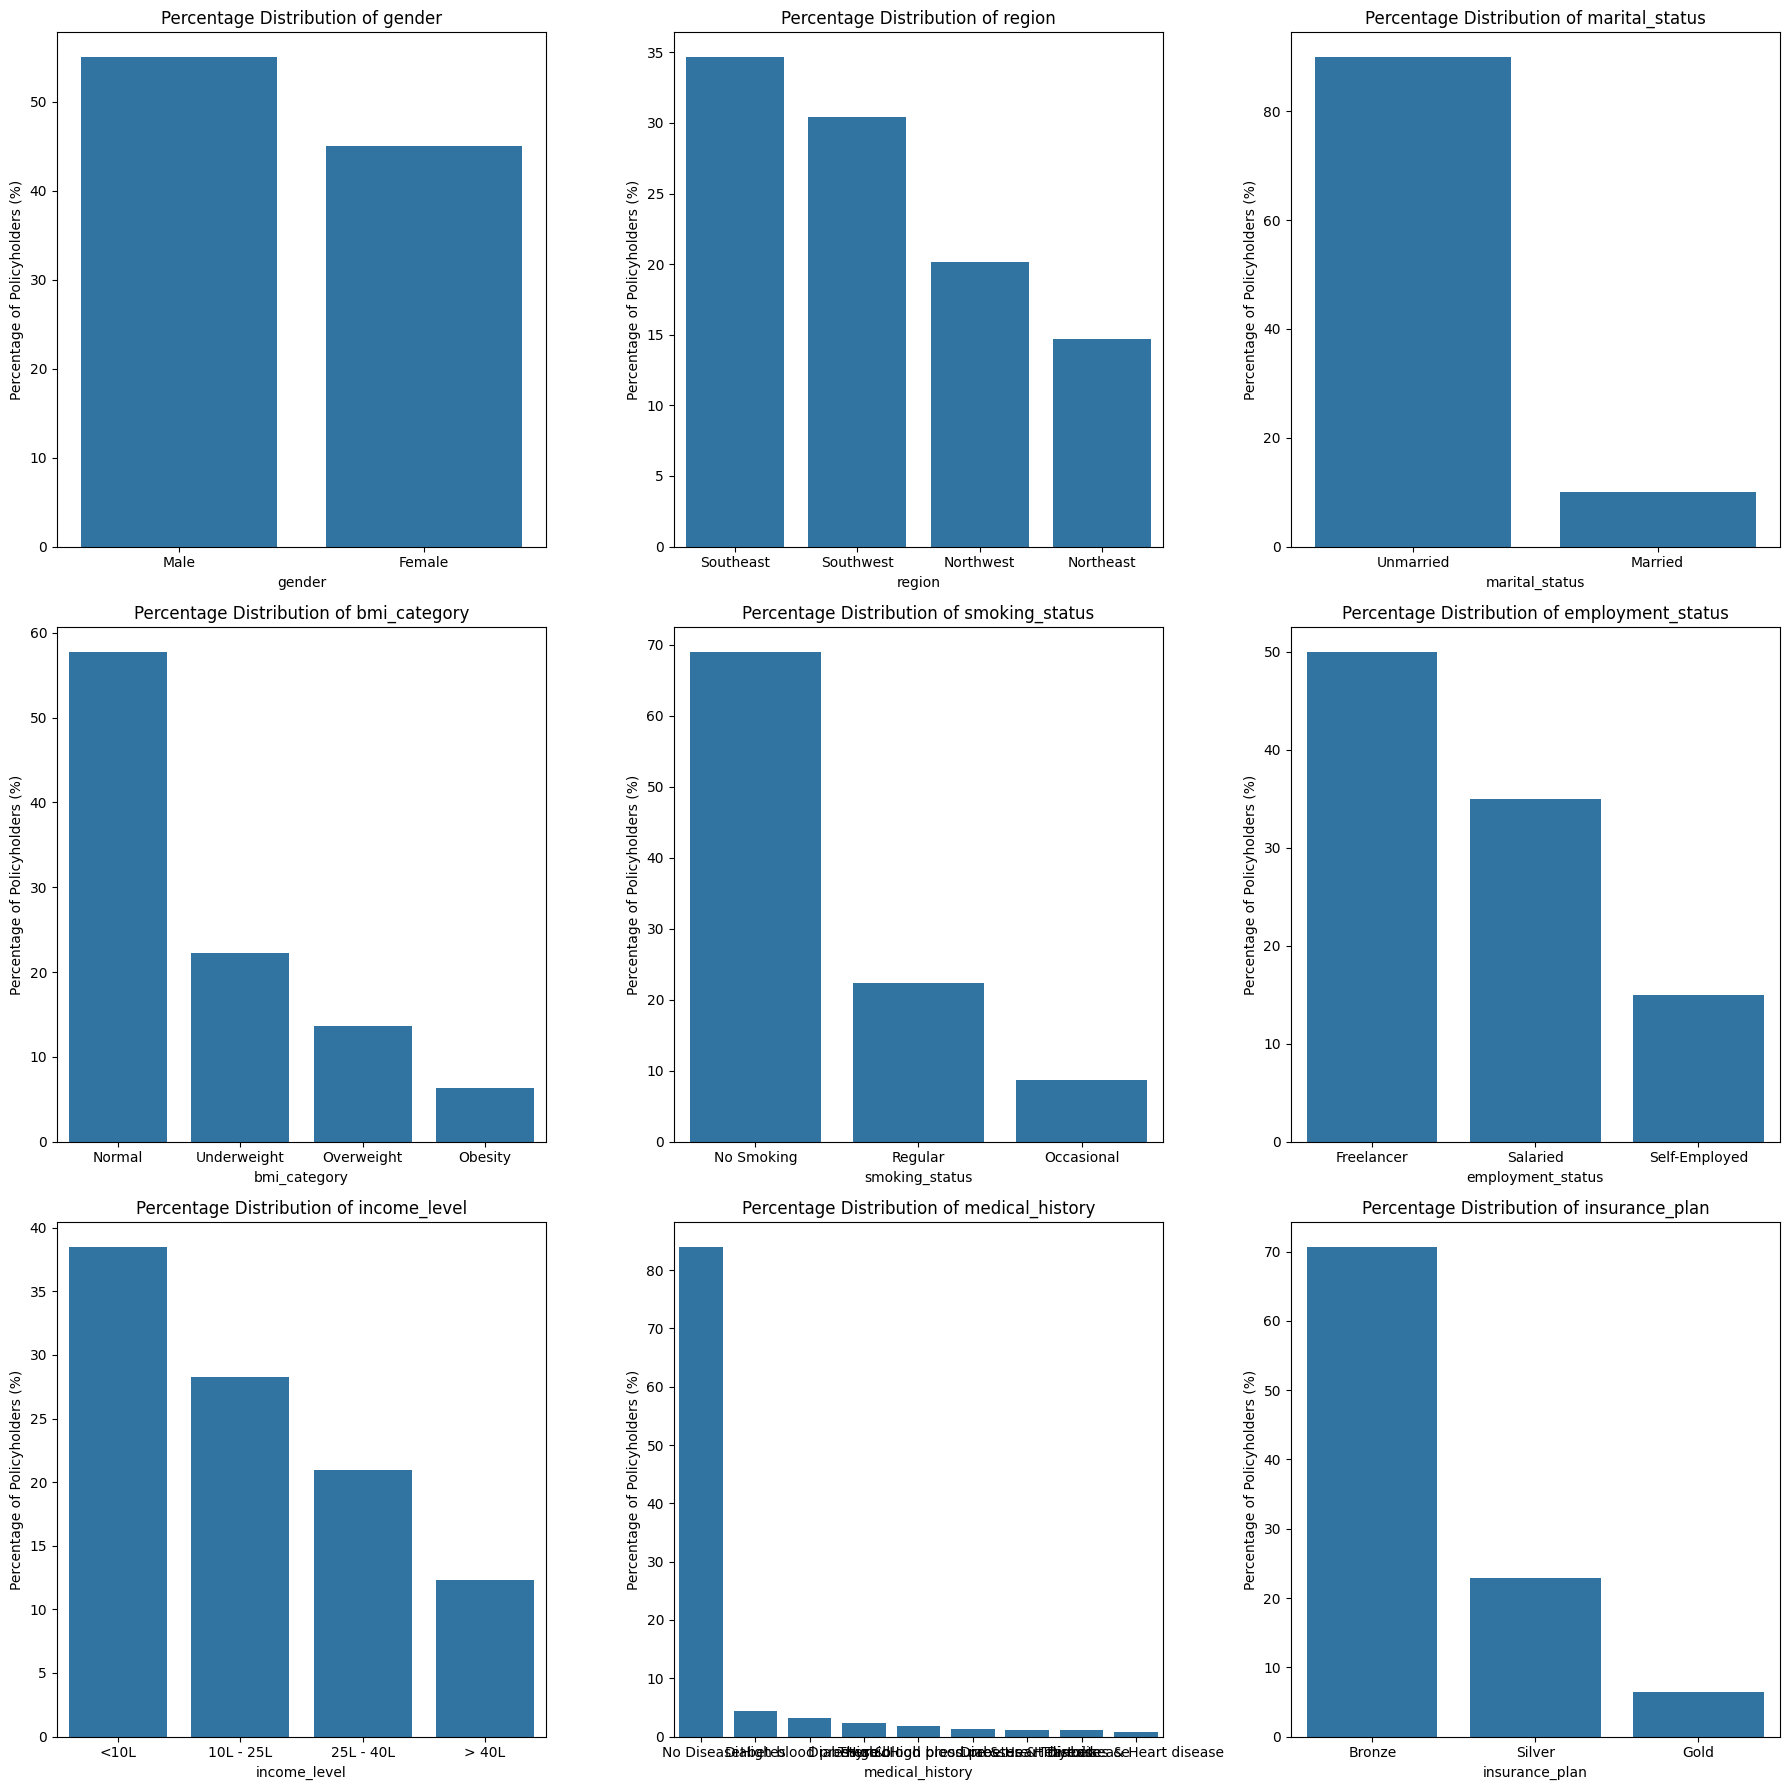

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  
axes = axes.flatten()  

for ax, column in zip(axes, categorical_cols):
    category_counts = df2[column].value_counts(normalize=True) * 100  

    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column) 

plt.tight_layout() 
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   362    1995


<Axes: xlabel='income_level'>

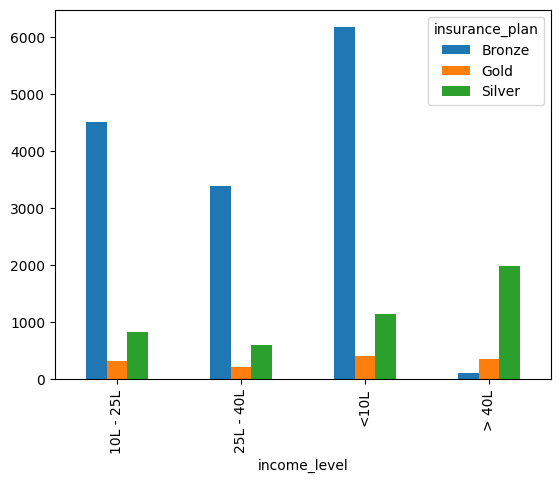

In [24]:
cross_stab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(cross_stab)

cross_stab.plot(kind = "bar")

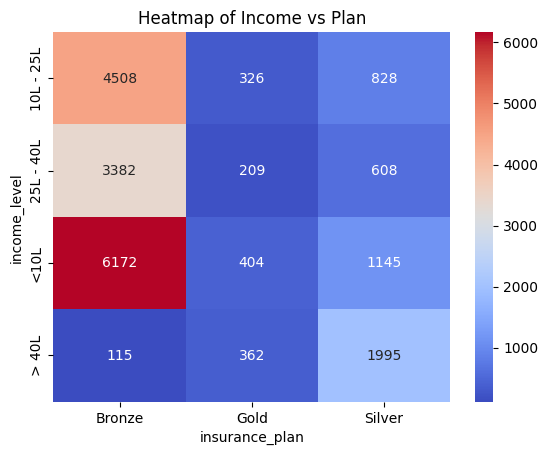

In [25]:
sns.heatmap(cross_stab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

## Feature Engineering

In [26]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [27]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())


In [28]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)

df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0,0.000000


In [29]:
df2.head(2)


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


In [30]:
df2['insurance_plan'].unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [31]:
df2['insurance_plan'] = df2['insurance_plan'].map({
    'Bronze' : 1,
    'Silver' : 2,
    'Gold'   : 3
})

In [32]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,2,11050,no disease,none,0,0.000000


In [33]:
df2['income_level'].unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [34]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [35]:
df2['income_level'].unique()

array([4, 1, 2, 3])

In [36]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0


In [37]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


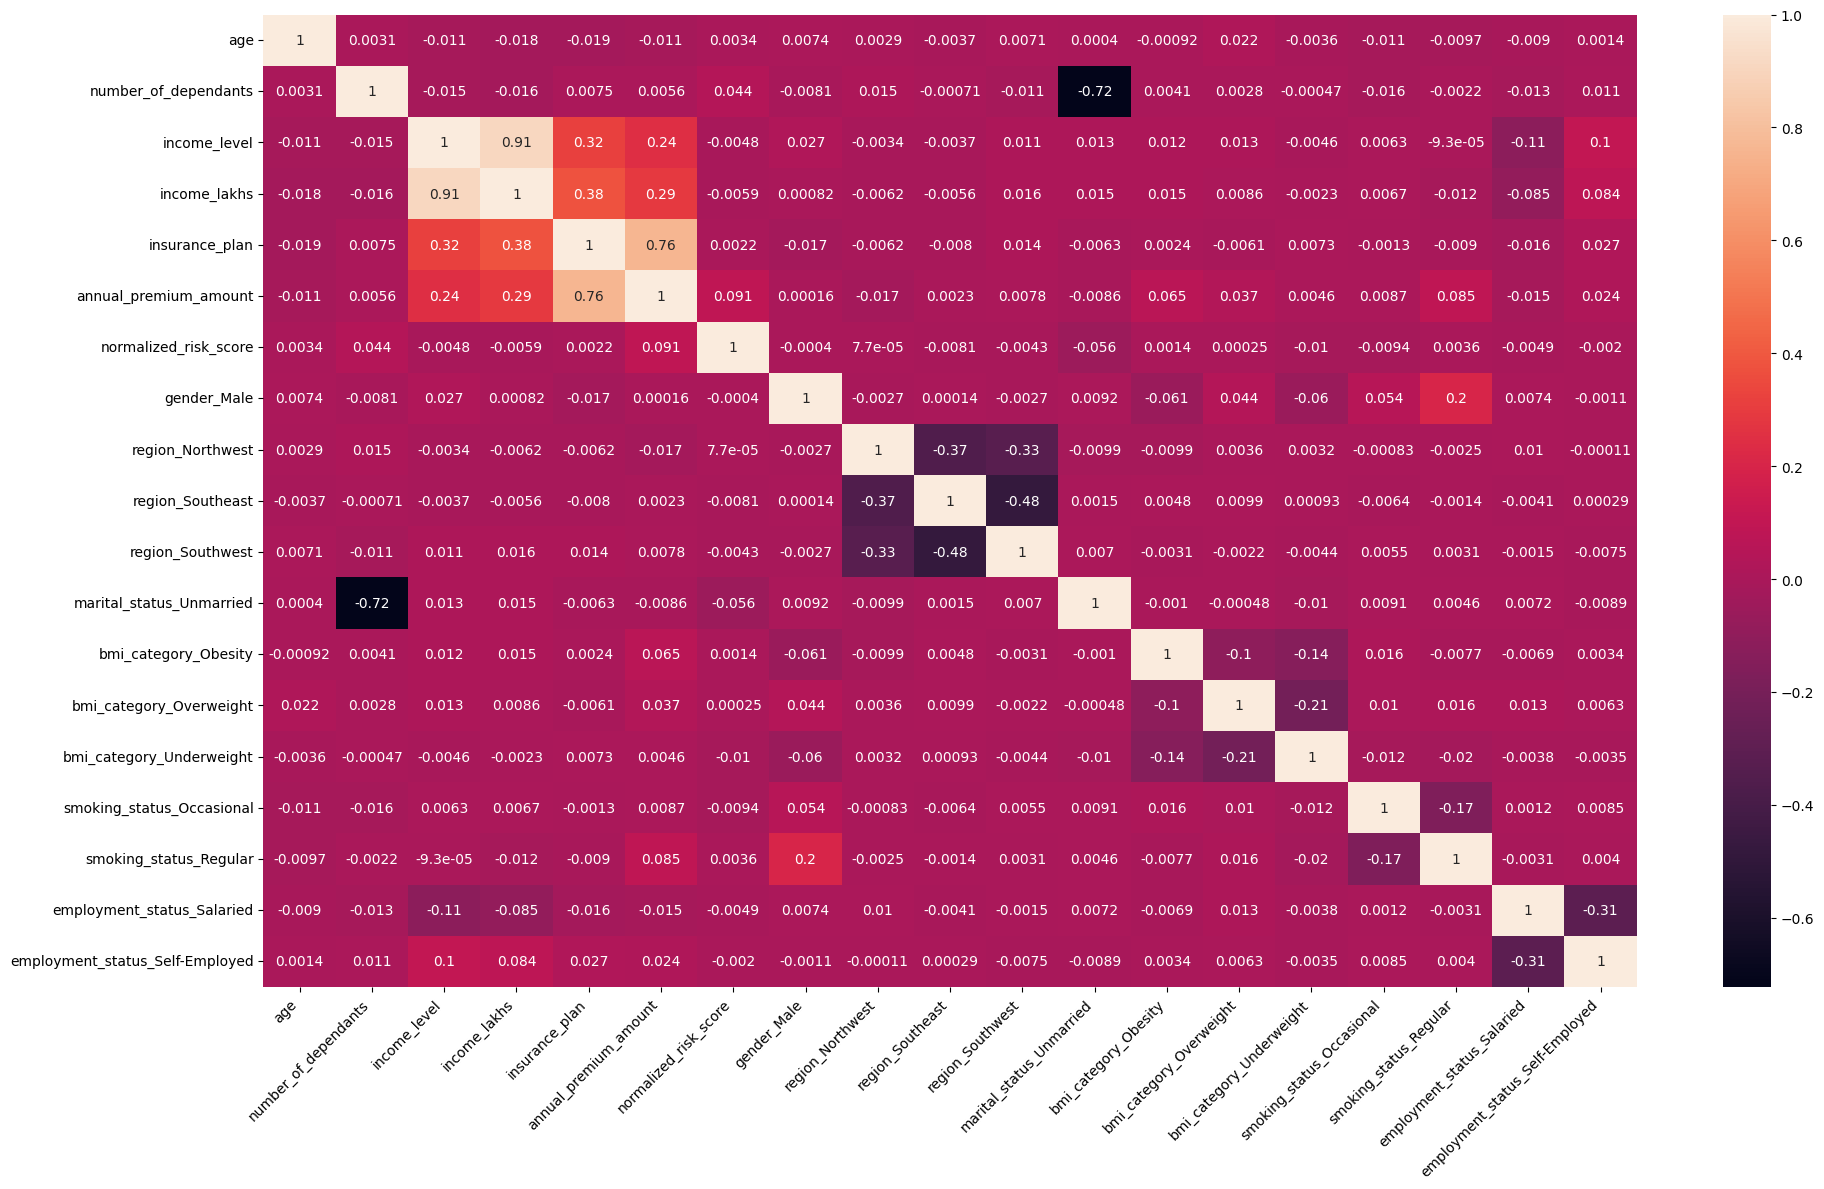

In [38]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [39]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000
mean,0.499145,0.240816,0.356970,0.217005,0.178967,0.092130,0.550364,0.201306,0.346863,0.304578,0.899920,0.063528,0.136531,0.222300,0.086417,0.223497,0.350155,0.149945
std,0.327769,0.312344,0.346809,0.219663,0.299827,0.230059,0.497469,0.400987,0.475984,0.460240,0.300114,0.243917,0.343360,0.415802,0.280985,0.416599,0.477030,0.357027
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.051020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.428571,0.000000,0.333333,0.153061,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.306122,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [41]:
calculate_vif(X)

,Column,VIF
0,age,3.142125
1,number_of_dependants,1.860137
2,income_level,12.076228
3,income_lakhs,12.064125
4,insurance_plan,1.586966
5,normalized_risk_score,1.154327
6,gender_Male,2.309901
7,region_Northwest,2.147121
8,region_Southeast,2.968665
9,region_Southwest,2.730084


In [42]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,3.140709
1,number_of_dependants,1.857617
2,income_lakhs,2.293723
3,insurance_plan,1.581668
4,normalized_risk_score,1.154291
5,gender_Male,2.299671
6,region_Northwest,2.146229
7,region_Southeast,2.967484
8,region_Southwest,2.729448
9,marital_status_Unmarried,7.305480


In [43]:
X_reduced = X.drop('income_level', axis="columns")

## Model Training

### Linear Regression Model

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.3, random_state=10)

In [45]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)

print(f"train score : {train_score}, test_score : {test_score}")

train score : 0.6048350981759056, test_score : 0.5964252843262741


In [46]:
model_lr.intercept_

6542.521635489461

In [47]:
model_lr.coef_

array([ 7.26389744e+01, -1.51679170e+01,  6.04888843e+00,  7.00382876e+03,
        1.03703478e+03, -3.14881122e+01, -8.95715718e+01,  9.05237749e+00,
       -5.03905309e+01, -3.11130924e+01,  7.50869774e+02,  4.32893765e+02,
        1.04140913e+02,  3.03204022e+02,  6.60132731e+02, -2.57407237e+01,
        1.56223624e+01])

In [48]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [49]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns = ['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending = True)
coef_df

,Coefficients
region_Northwest,-89.571572
region_Southwest,-50.390531
gender_Male,-31.488112
marital_status_Unmarried,-31.113092
employment_status_Salaried,-25.740724
number_of_dependants,-15.167917
income_lakhs,6.048888
region_Southeast,9.052377
employment_status_Self-Employed,15.622362
age,72.638974


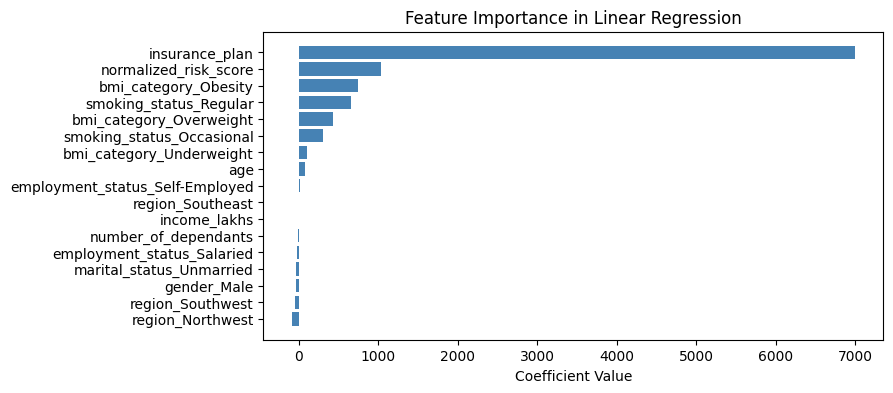

In [50]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [51]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.6048346412141938, 0.5964335620224849)

In [52]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  3064069.439917855 RMSE:  1750.4483539704493


### XGBoost Model

In [53]:
model_xgb = XGBRegressor()

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.5569512270247807

In [54]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  3363838.213281027 RMSE:  1834.0769376667456


### XGBoost Model Finetuning

In [55]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.6018239672149338

In [56]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [57]:
best_model = random_search.best_estimator_

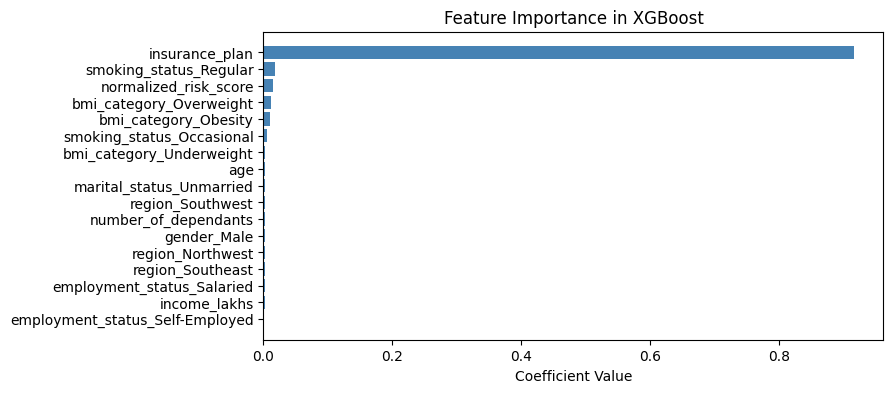

In [58]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns = ['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending = True)
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### Error Analysis

In [59]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
1710,4096,6981.050781,2885.050781,70.435810
11963,4503,6981.050781,2478.050781,55.031108
8719,8332,10772.823242,2440.823242,29.294566
7208,11578,10084.492188,-1493.507812,-12.899532
9416,7045,6570.482422,-474.517578,-6.735523


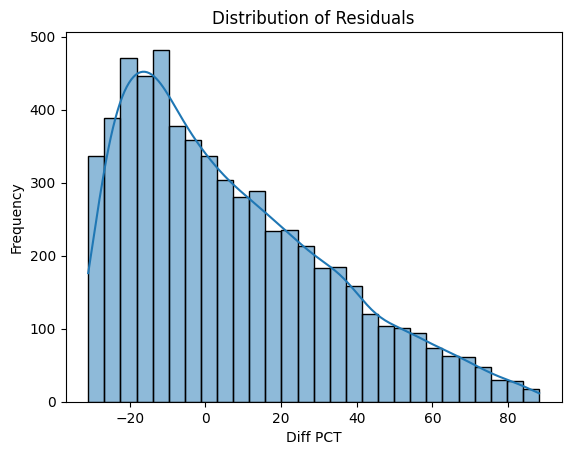

In [60]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [61]:
extreme_error_threshold = 10

extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4427, 4)

In [62]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

73.57487119827157

In [63]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct
10165,3501,6588.262207,3087.262207,88.182297
14598,3501,6588.262207,3087.262207,88.182297
18500,3508,6595.966309,3087.966309,88.026406
17197,3508,6588.262207,3080.262207,87.806790
4169,3517,6595.966309,3078.966309,87.545246
...,...,...,...,...
4855,4393,6595.966309,2202.966309,50.147196
813,4631,6952.925293,2321.925293,50.138745
18326,4633,6955.566895,2322.566895,50.130950
1597,4653,6981.050781,2328.050781,50.033329


In [64]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
1710,0.714286,0.0,0.040816,0.0,0.0,0,0,1,0,1,0,1,0,0,0,0,0
11963,1.000000,0.0,0.051020,0.0,0.0,1,0,1,0,1,0,1,0,0,0,0,0


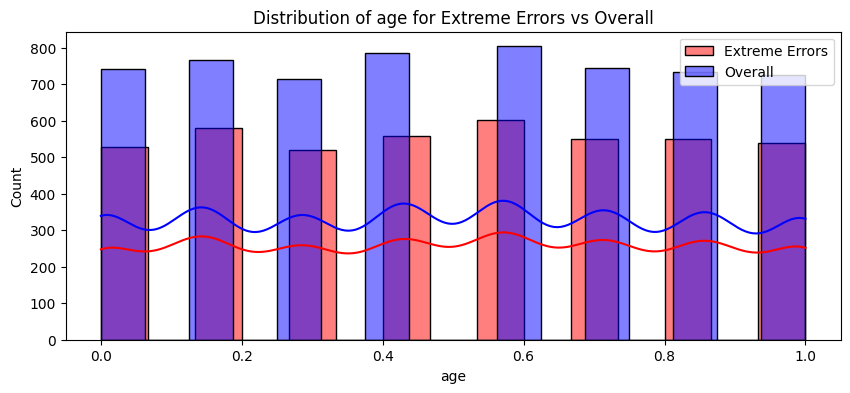

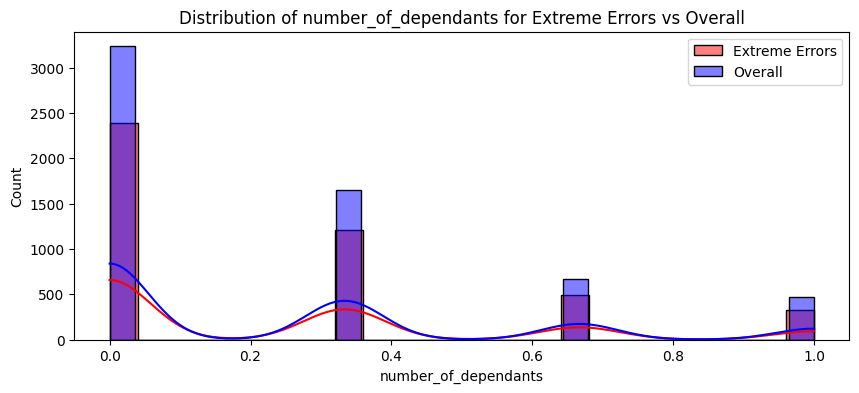

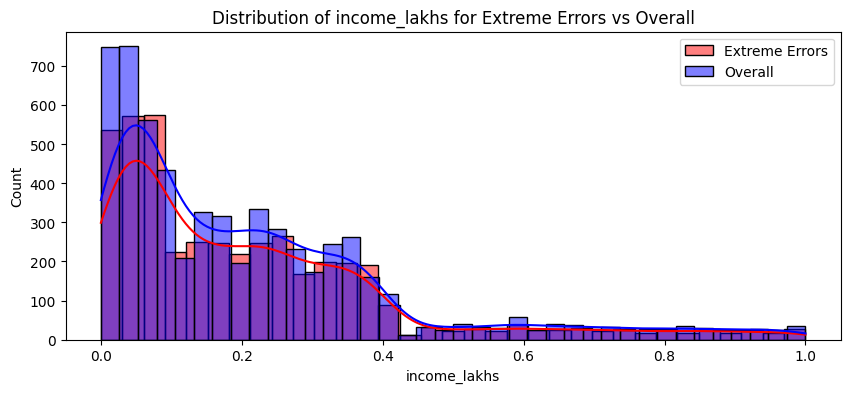

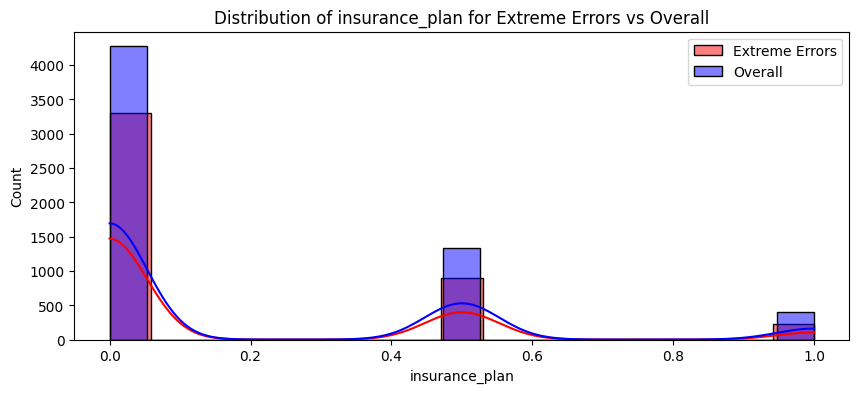

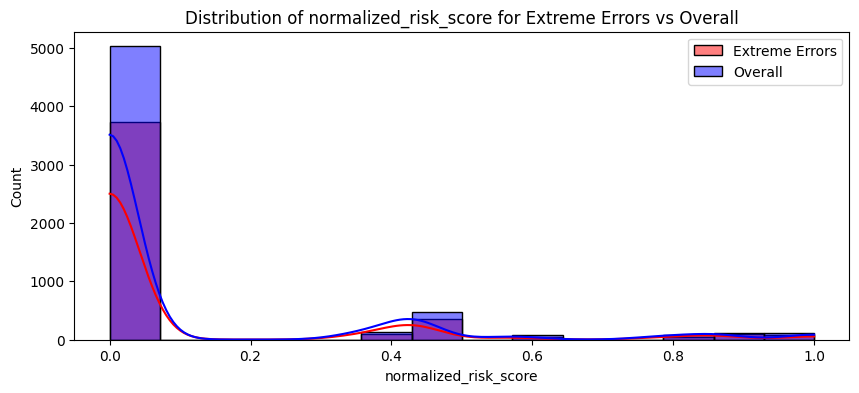

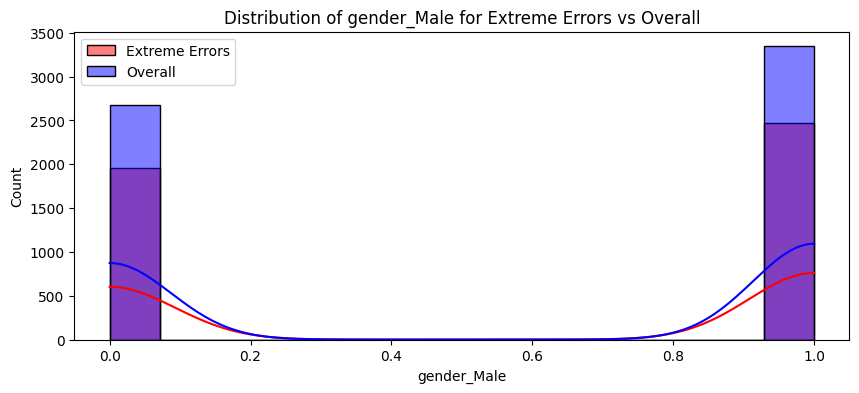

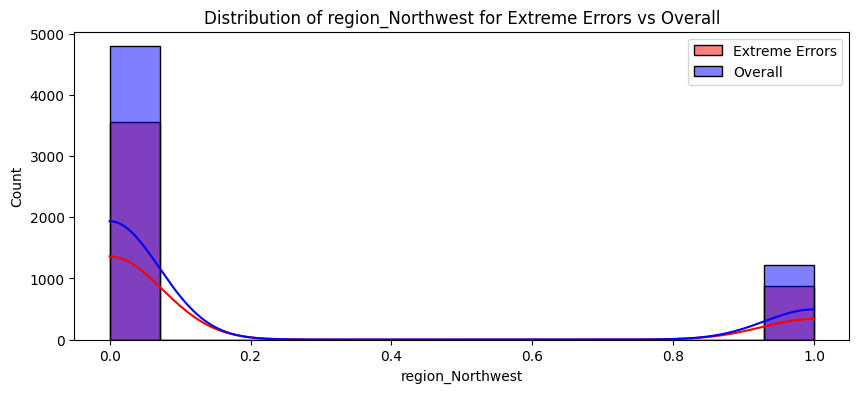

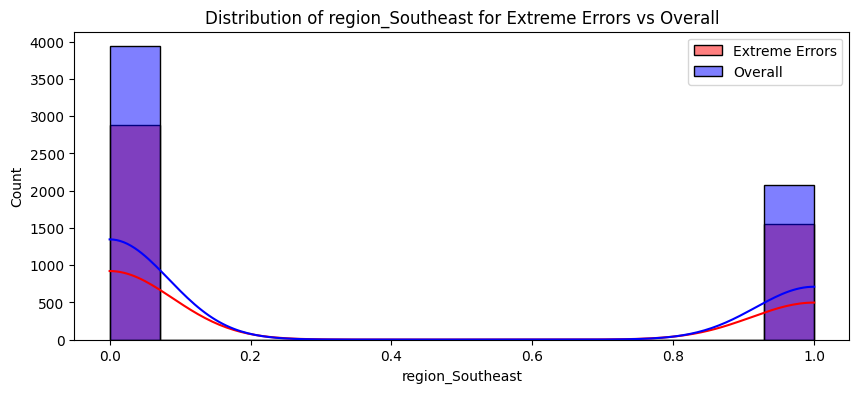

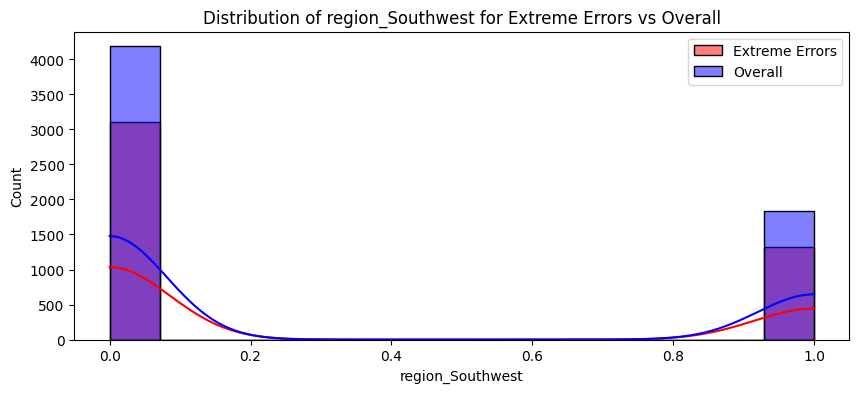

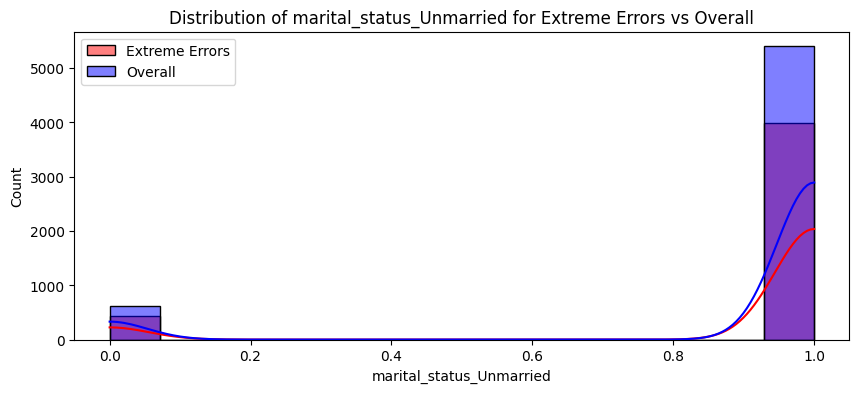

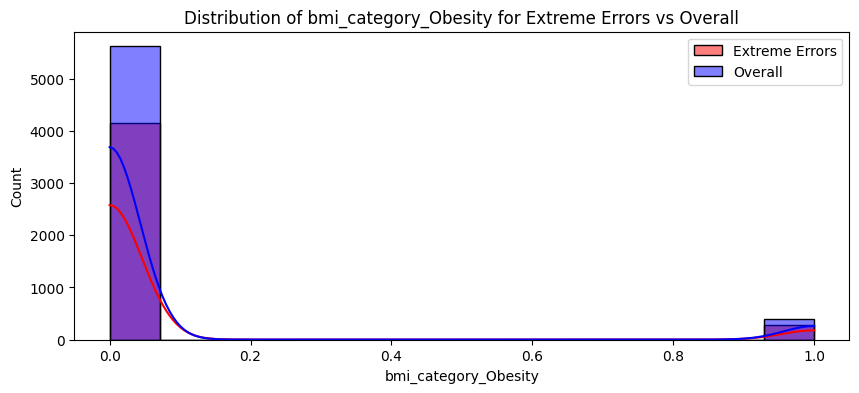

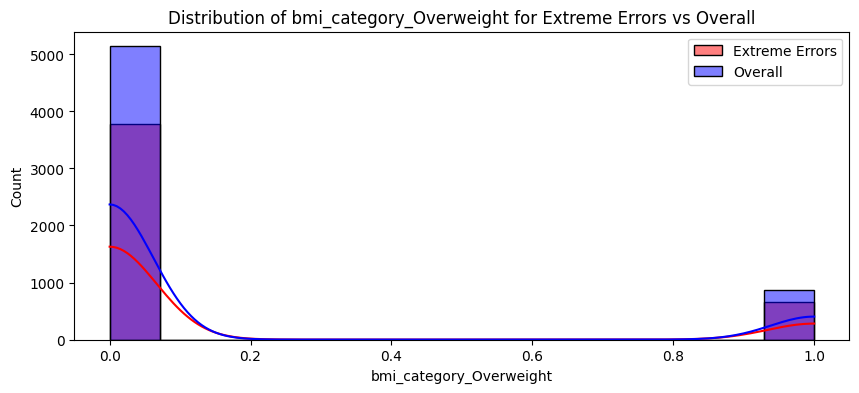

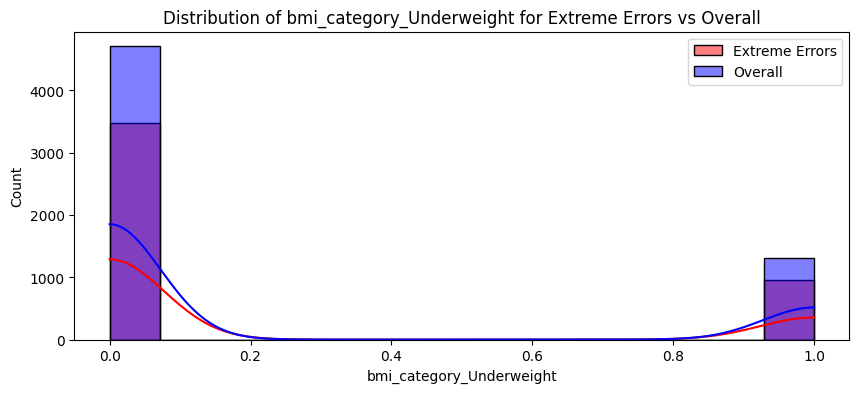

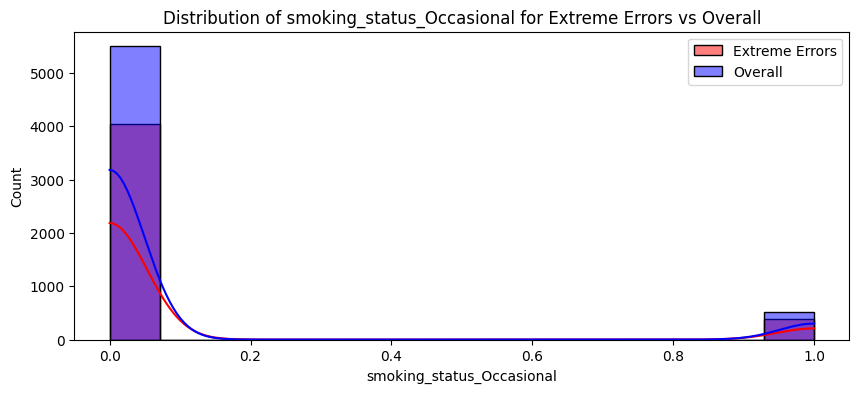

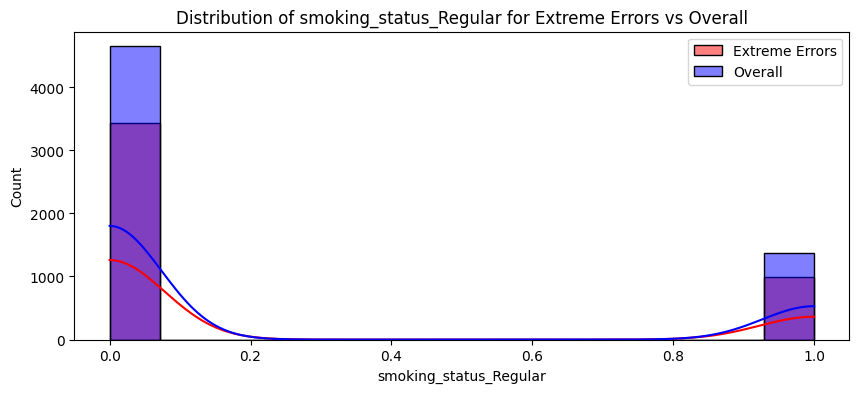

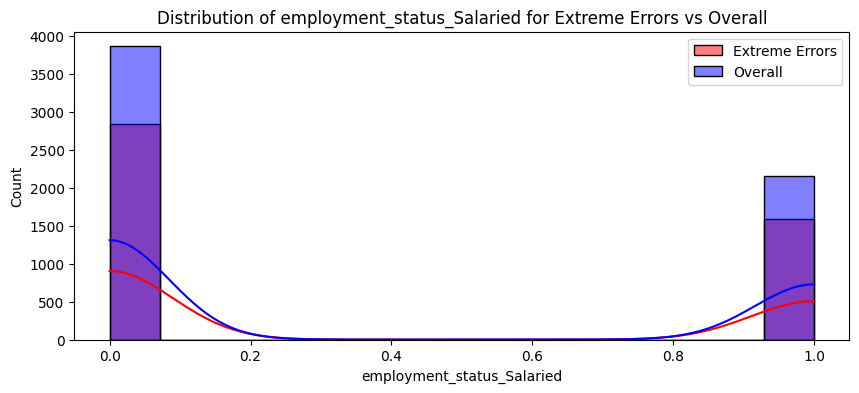

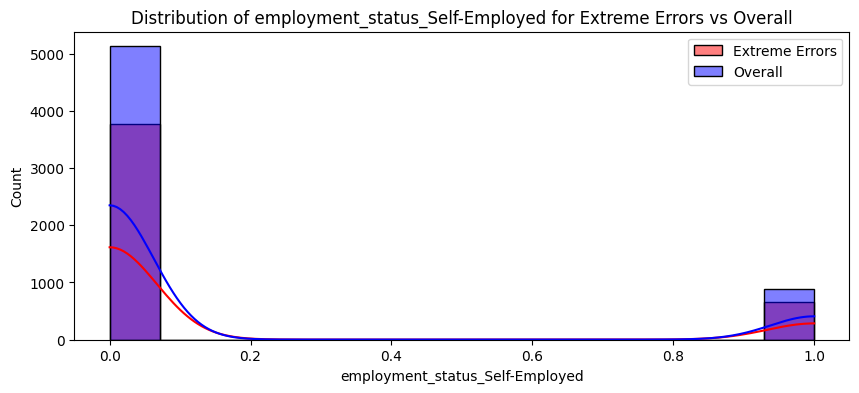

In [65]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

### Reverse Sacaling

In [66]:
extreme_errors_df['income_level']=-1

In [67]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,0.0,-2.0,5.0,1.0
1,25.0,0.0,-2.0,6.0,1.0
2,21.0,0.0,-2.0,7.0,2.0
3,22.0,3.0,-2.0,27.0,2.0
4,18.0,0.0,-2.0,25.0,1.0


In [68]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4427.000000,4427.000000,4427.0,4427.000000,4427.000000
mean,21.507341,0.720578,-2.0,21.719901,1.307206
std,2.271183,0.934037,0.0,20.485006,0.564462
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,19.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,16.000000,1.000000
75%,23.000000,1.000000,-2.0,31.000000,2.000000
max,25.000000,3.000000,-2.0,99.000000,3.000000


<Axes: xlabel='age', ylabel='Count'>

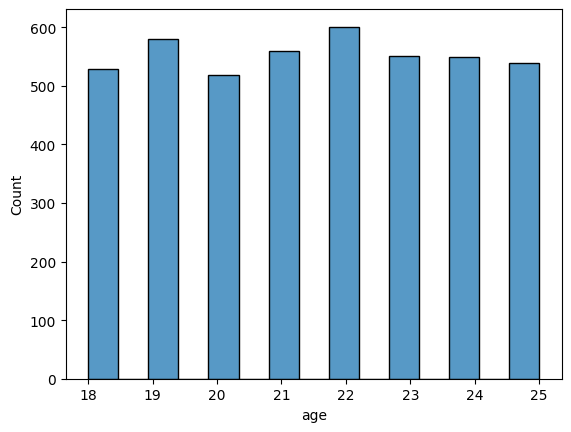

In [69]:
sns.histplot(df_reversed.age)